In [1]:
# Define SI unit prefixes
nm = nHz = nA = nV = nW = ns = 1e-9
um = uHz = uA = uV = uW = us = 1e-6
mm = mHz = mA = mV = mW = ms = 1e-3
cm = 1e-2
Hz = A = V = W = s =1
kHz = kA = kV = kW = 1e3
MHz = MA = MV = MW = 1e6
GHz = GA = GV = GW = 1e9

In [2]:
"""How much light can we shine at the camera?
we know:
- the camera's quantum efficiency - 35%
- the camera's pixel size - 6.45um
- the cameras full well depth - 16000 electrons
- minimum exposure time - 1us
- the power in a gaussian beam of 2cm diameter magnifified by 3 on a pixel

so find out if we throw more than the full well depth at the cameras highest pixel
"""
import numpy as np

camera_full_well_depth = 16000 # electrons
camera_quantum_efficiency = 0.35
camera_exposure_time = 1*ms

# power in the central 6.45um pixel of a rad=10mm 1/e^2 gaussian beam (then imaged down 3x)
# integral 2D gaussian beam e^-(r)^2 * 2*Pi*r*dr
# from 0 to r=(6.45um/3.333mm) = 0.0000117652
# from 0 to r = 1.9859

full_well_photons = 16000/camera_quantum_efficiency
overexposed_photons = full_well_photons * 1.9859 / 0.0000117652
overexposed_energy = overexposed_photons * 2.547e-19  # J
overexposed_power = overexposed_energy / camera_exposure_time  # W

print(f"max power before the camera cries is {overexposed_power/uW:.2f}uW if exposed for {camera_exposure_time/us:.2f}us")

max power before the camera cries is 1.97uW if exposed for 1000.00us


We will pull the data straight out of the Artiq master dataset so expect some wrangling to get it looking nice

In [3]:
import asyncio
from sipyco.sync_struct import Subscriber

# Create an asyncio Event to wait for updates
dataset_updated = asyncio.Event()

async def connect_subscriber(name, db: dict, port=None, server=None):
    port = 3250 if port is None else port
    server = "137.222.69.28" if server is None else server

    def _create(data):
        db.update(data)
        return db

    def _update(mod):
        # Signal that an update has occurred
        dataset_updated.set()

    subscriber = Subscriber(name, _create, _update, None)
    try:
        await subscriber.connect(
            server,
            port,
        )
    except asyncio.TimeoutError:
        print(f"Failed to connect to Sub: {name} at {server}:{port}")
        return
    print(f"Connected to Sub: {name} at {server}:{port}")
    return subscriber


This is the absoroption image fitting class

In [4]:
# Run the connection in an asyncio event loop
db = {}
sub = await connect_subscriber("datasets", db)
await dataset_updated.wait()
# await sub.close()
print("Received dataset update!")

Connected to Sub: datasets at 137.222.69.28:3250
Received dataset update!


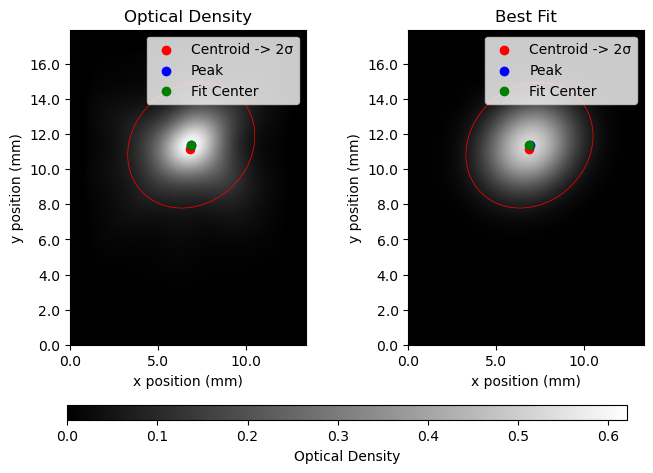

In [14]:
import sys, os
sys.path.append(os.path.abspath("../"))
from repository.imaging.absorption_image import AbsImage

data = db["Images.absorption.TOF"][1]
ref = db["Images.absorption.REF"][1]
bg = db["Images.absorption.BG"][1]

# abs_img = AbsImage(data, ref, bg, magnification=3)

abs_img=AbsImage.fake(5)

_ = abs_img.plot()

In [6]:
"""
TOF:

fit x: np.square(self.independent_var + config.repump_time)
fit y: np.square(self.sigma_x) and np.square(self.sigma_y)

temp = slope * shot.atom_mass / KB

use centroids instead of fitted locations for nicer results when held?

"""

'\nTOF:\n\nfit x: np.square(self.independent_var + config.repump_time)\nfit y: np.square(self.sigma_x) and np.square(self.sigma_y)\n\ntemp = slope * shot.atom_mass / KB\n\nuse centroids instead of fitted locations for nicer results when held?\n\n'